#Library imports

In [1]:
%tensorflow_version 1.15
import numpy as np
import PIL
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.models import *
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract
from keras.utils import plot_model
from keras.optimizers import Adam
from IPython.display import clear_output
import cv2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


#Dataset loading

In [2]:
!cp /content/drive/"My Drive"/"images.rar" /content/
!unrar x "images.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from images.rar

Creating    images                                                    OK
Creating    images/noise_images                                       OK
Extracting  images/noise_images/blur_149.jpg                               0%  OK 
Extracting  images/noise_images/blur_150.jpg                               0%  OK 
Extracting  images/noise_images/blur_151.jpg                               0%  OK 
Extracting  images/noise_images/blur_152.jpg                               0%  OK 
Extracting  images/noise_images/blur_153.jpg                               0%  OK 
Extracting  images/noise_images/blur_154.jpg                               0%  OK 
Extracting  images/noise_images/blur_155.jpg                               0%  OK 
Extracting  images/noise_images/blur_156.jpg                               0%  OK 
Extracting  images/no

#Dataset preprocessing

In [3]:
def gen_patches(file_name,patch_size, stride):

    
    img2 = Image.open(file_name)
    img = ImageOps.grayscale(img2)
    h, w = img.size
    scales = [1, 0.9, 0.8, 0.7]
    patches = []
    for s in scales:
        h_scaled, w_scaled = int(h*s),int(w*s)
        scaled = img.resize((h_scaled, w_scaled) ,PIL.Image.LANCZOS)
        scaled = np.array(scaled)
  
        for i in range(0, w_scaled-patch_size+1, stride):
            for j in range(0, h_scaled-patch_size+1, stride):
                x = scaled[i:i+patch_size, j:j+patch_size]
                patches.append(x)
    
    return patches

#patches = gen_patches('noise_3.jpg',120,10)
#patches = np.array(patches)
#i=5
#plt.imshow(patches[i])
#img = Image.open('noise_3.jpg')
#img2 = img.convert('LA')
    
#plt.imshow(img2)

In [4]:
noisy_path='/content/images/noise_images/'
orig_path='/content/images/orig_images/'

img_list = [x for x in os.listdir(orig_path) if 'salt' in x]

original_dataset = []
noisy_dataset = []

count = 0
for img in img_list:
    orig_patches = gen_patches( os.path.join( orig_path,img ),40,40 )
    noisy_patches = gen_patches( os.path.join( noisy_path,img ),40,40 )
    count+=1
    
    for patch in orig_patches:
      original_dataset.append(patch)

    for patch in noisy_patches:
      noisy_dataset.append(patch)

    clear_output(wait=False)
    print(count,"/",len(img_list)," images loaded.")
      
del orig_patches
del noisy_patches

original_dataset = np.array(original_dataset)/255.0
noisy_dataset = np.array(noisy_dataset)/255.0

148 / 148  images loaded.


In [5]:
  original_dataset=np.reshape(original_dataset,(23450,40,40,1))
  noisy_dataset=np.reshape(noisy_dataset,(23450,40,40,1))
  print(original_dataset.shape)
  print(noisy_dataset.shape)

(23450, 40, 40, 1)
(23450, 40, 40, 1)


In [6]:
print(original_dataset.shape)

(23450, 40, 40, 1)


In [7]:
img_index = 45

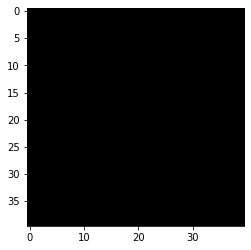

In [8]:
plt.imshow( np.reshape( original_dataset[img_index], (40,40) ),cmap = 'gray' )

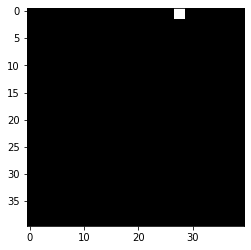

In [9]:
plt.imshow( np.reshape( noisy_dataset[img_index], (40,40) ),cmap='gray' )

#Model and hyperparameter tuning

##Beyond gaussian
Based on [this paper](http://www4.comp.polyu.edu.hk/~cslzhang/paper/DnCNN.pdf)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


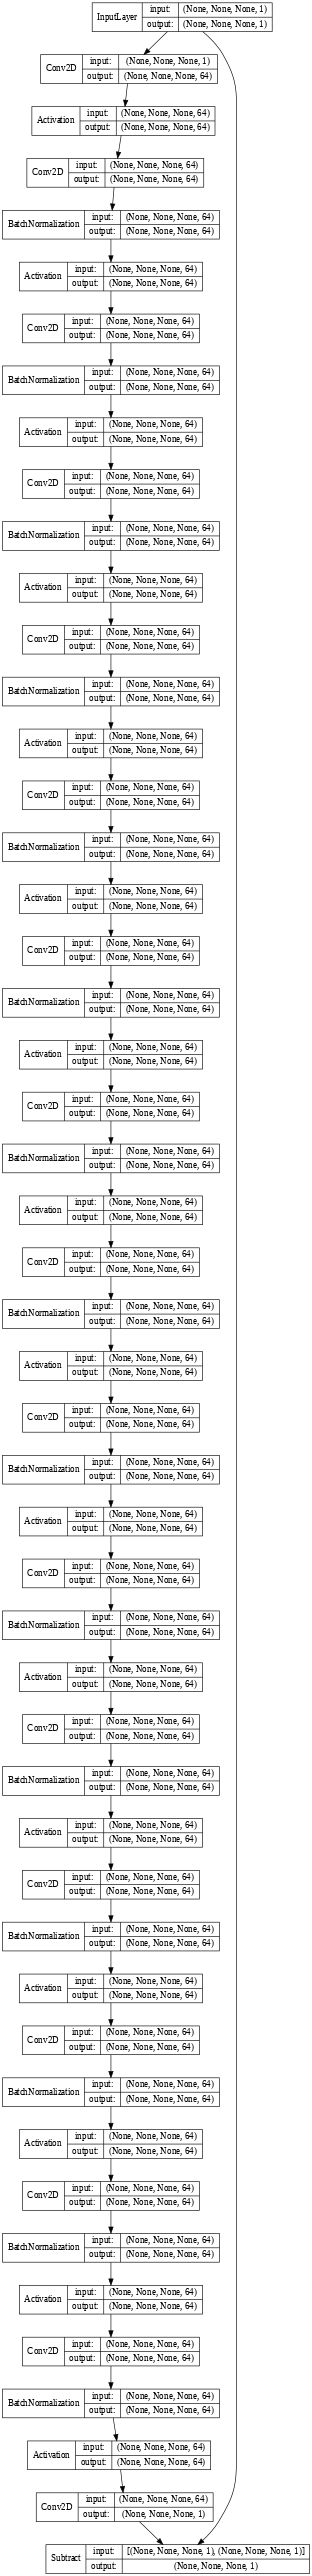

In [10]:
inpt = Input(shape=(None,None,1)) #none,none,1
   
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(inpt)
x = Activation('relu')(x)

for i in range(15):
  x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
  x = BatchNormalization(axis=-1, epsilon=1e-3)(x)
  x = Activation('relu')(x)   

x = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Subtract()([inpt, x])
model = Model(inputs=inpt, outputs=x)
optim = Adam(lr=0.01,decay=0.0001)
model.compile(optimizer=optim,loss='mean_squared_error',metrics=['accuracy'])
plot_model(model,show_layer_names=False,show_shapes=True,dpi=45)

##Model training

In [ ]:
epochs = 28000
batch_size = 256
display_frequency = 100
save_frequency = 1500
continue_training = False

if continue_training:
  model = load_model('gauss0.h5')
  print('model loaded!')

for i in range(epochs):
  indexes = np.random.randint(0,original_dataset.shape[0],size=batch_size )
  original_dataset_batch = original_dataset[ indexes ]   
  noisy_dataset_batch = noisy_dataset[ indexes ]

  acc = model.train_on_batch(noisy_dataset_batch,original_dataset_batch)
  if i % display_frequency == 0:
    clear_output(wait=True)
    print(i,"/",epochs,"epochs.")
    print(acc)
  if i % save_frequency == 0:
    model.save('salt'+str(i)+'.h5')


27900 / 28000 epochs.
[0.00027020054, 0.10994141]


In [ ]:
!cp "salt27900.h5" "/content/drive/My Drive/"

cp: cannot stat 'salt27900.h5': No such file or directory


##Testing model

In [11]:
import cv2
clean_str='/content/images/orig_images/salt_614.jpg'
noise_str='/content/images/noise_images/salt_614.jpg'
img_clean = cv2.imread(clean_str)
img_clean = cv2.cvtColor(img_clean, cv2.COLOR_BGR2RGB)/255
img_test = cv2.imread(noise_str)
img_test = img_test/255

img_testb,img_testg,img_testr = cv2.split(img_test)

img_testr = img_testr.reshape(1, img_clean.shape[0], img_clean.shape[1], 1)  
img_testg = img_testg.reshape(1, img_clean.shape[0], img_clean.shape[1], 1)  
img_testb = img_testb.reshape(1, img_clean.shape[0], img_clean.shape[1], 1)  

y_predict_r = model.predict(img_testr)
y_predict_g = model.predict(img_testg)
y_predict_b = model.predict(img_testb)

img_out_r = y_predict_r.reshape(img_clean.shape[0], img_clean.shape[1], 1)
img_out_g = y_predict_g.reshape(img_clean.shape[0], img_clean.shape[1], 1)
img_out_b = y_predict_b.reshape(img_clean.shape[0], img_clean.shape[1], 1)

img_out = cv2.merge( (img_out_b,img_out_g,img_out_r) )
img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
img_out = np.clip(img_out, 0, 1)

INPUT


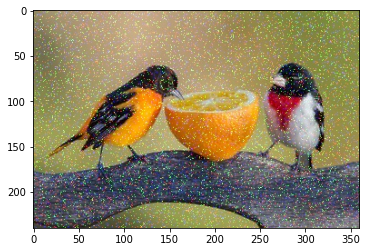

In [12]:
print("INPUT")
INPUT = cv2.imread(noise_str)
INPUT = cv2.cvtColor(INPUT, cv2.COLOR_BGR2RGB)
plt.imshow(INPUT)

OUTPUT


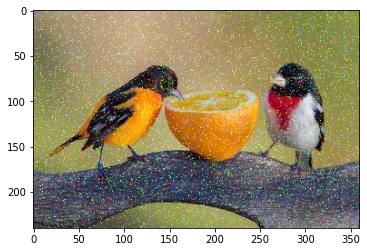

In [13]:
print("OUTPUT")
plt.imshow(img_out)

EXPECTED


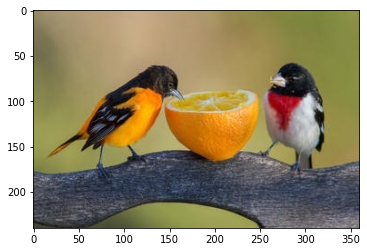

In [14]:
print("EXPECTED")
EXPECTED = cv2.imread(clean_str)
EXPECTED = cv2.cvtColor(EXPECTED, cv2.COLOR_BGR2RGB)
plt.imshow(EXPECTED)

##Save/Fetch pretrained model

In [ ]:
#Save
!cp /content/salt27000.h5 "/content/drive/My Drive/"

In [ ]:
#Fetch
!cp "/content/drive/My Drive/salt27000.h5.h5" ./

##Loading pretrained model

In [ ]:
model = load_model('speckledenoising27000.h5')

##Run inference

In [ ]:
import cv2
clean_str='/content/images/orig_images/speckle_589.jpg'
noise_str='/content/images/noise_images/speckle_589.jpg'
img_clean = cv2.imread(clean_str)
img_clean = cv2.cvtColor(img_clean, cv2.COLOR_BGR2RGB)/255
img_test = cv2.imread(noise_str)
img_test = img_test/255

img_testb,img_testg,img_testr = cv2.split(img_test)

img_testr = img_testr.reshape(1, img_clean.shape[0], img_clean.shape[1], 1)  
img_testg = img_testg.reshape(1, img_clean.shape[0], img_clean.shape[1], 1)  
img_testb = img_testb.reshape(1, img_clean.shape[0], img_clean.shape[1], 1)  

y_predict_r = model.predict(img_testr)
y_predict_g = model.predict(img_testg)
y_predict_b = model.predict(img_testb)

img_out_r = y_predict_r.reshape(img_clean.shape[0], img_clean.shape[1], 1)
img_out_g = y_predict_g.reshape(img_clean.shape[0], img_clean.shape[1], 1)
img_out_b = y_predict_b.reshape(img_clean.shape[0], img_clean.shape[1], 1)

img_out = cv2.merge( (img_out_b,img_out_g,img_out_r) )
img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
img_out = np.clip(img_out, 0, 1)

In [ ]:
print("INPUT")
INPUT = cv2.imread(noise_str)
INPUT = cv2.cvtColor(INPUT, cv2.COLOR_BGR2RGB)
plt.imshow(INPUT)

In [ ]:
print("OUTPUT")
plt.imshow(img_out)

In [ ]:
print("EXPECTED")
EXPECTED = cv2.imread(clean_str)
EXPECTED = cv2.cvtColor(EXPECTED, cv2.COLOR_BGR2RGB)
plt.imshow(EXPECTED)